In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import preprocessing
import pipeline

# Basic Pipeline + Basic Model 

### Imports

In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold

### Download DataFrame

In [4]:
df = preprocessing.preprocess()

/Users/pilou/code/llenci/real-estate-tracker/notebooks/preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonull["surface"] = new[0]
/Users/pilou/code/llenci/real-estate-tracker/notebooks/preprocessing.py:38: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new[0] = new[0].str.replace(".","")
/Users/pilou/code/llenci/real-estate-tracker/notebooks/preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [37]:
df = df.reset_index()
df

,index,price,rooms,surface,neighborhood,nhousetype
0,0,566500.0,2.0,87.0,Chamberí,Piso
1,1,310500.0,3.0,78.0,Retiro,Piso
2,2,220000.0,4.0,103.0,Carabanchel,Piso
3,3,171000.0,2.0,81.0,Villa de Vallecas,Piso
4,4,369000.0,3.0,83.0,Centro,Piso
...,...,...,...,...,...,...
5751,295,515000.0,4.0,106.0,Centro,Piso
5752,296,280000.0,3.0,99.0,San Blas,Piso
5753,297,182100.0,1.0,52.0,Villaverde,Ático
5754,298,220000.0,1.0,42.0,Centro,Ático


In [38]:
df.drop(columns = ['index'] , inplace = True)

### Create X and y

In [39]:
X = df.drop(columns="price")
y = df[['price']]

### Create Pipeline

In [75]:
# num transformer
num_transformer = make_pipeline(RobustScaler())

# cat transformer
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown="ignore",
                                              sparse = False))

# Preproc basic 
preproc_basic = make_column_transformer((num_transformer, ['rooms','surface']),
                                        (cat_transformer,['neighborhood','nhousetype']))              

### Apply Pipeline to X

In [76]:
X_final = preproc_basic.fit_transform(X)

### Create X_final and y_final

In [77]:
X_final

array([[-1.        , -0.04285714,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        , -0.17142857,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.18571429,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-2.        , -0.54285714,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-2.        , -0.68571429,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        , -0.34285714,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

In [78]:
y_final = y

### Train Test Split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final,test_size=0.3)

### Baseline Model

In [80]:
y_train.mean()

price    541789.409779
dtype: float64

In [81]:
dummy_prediction = y_train.mean()[0]*np.ones(y_test.shape)
dummy_error = mean_squared_log_error(y_test , dummy_prediction)**0.5
dummy_error

0.9093213716673502

### Custom Cross Validation Function 

In [82]:
model = XGBRegressor()

In [93]:
def customCrossValidation( model , X , y , cv = 5 , shuffle = True):
    scores = []
    kf = KFold(n_splits = cv , shuffle = True)
    
    if isinstance(y , pd.DataFrame):
        y = y.to_numpy()
    
    run = 1
    for train_index , test_index in kf.split(X):
        print(f'{run=}')
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train , X_test = X[train_index] , X[test_index]
        y_train , y_test = np.log(y[train_index]) , y[test_index]
        model.fit(X_train , y_train)
        prediction = np.exp(model.predict(X_test))
        error = mean_squared_log_error(y_test , prediction)**0.5
        scores.append(error)
        run += 1
    return {"test_score" : np.array(scores) }

In [94]:
cv = customCrossValidation( model , X_final , y_final , cv = 5 )
score = cv["test_score"].mean()
score

run=1
TRAIN: 4604 TEST: 1152
run=2
TRAIN: 4605 TEST: 1151
run=3
TRAIN: 4605 TEST: 1151
run=4
TRAIN: 4605 TEST: 1151
run=5
TRAIN: 4605 TEST: 1151


0.27981670855748303

### GridSearch

In [ ]:
params = {
        'eta': [0.3,0.4,0.5],
        'max_depth': [2,3, 4],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,0.3,0.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [1,2,3, 4, 5]
        }
grid = GridSearchCV(model,params,verbose=1,n_jobs=-1,scoring=scorer)

In [ ]:
#search = grid.fit(X_train,y_train)

In [ ]:
#fit.best_score_

### Effect of Log on target

<AxesSubplot:xlabel='surface', ylabel='price'>

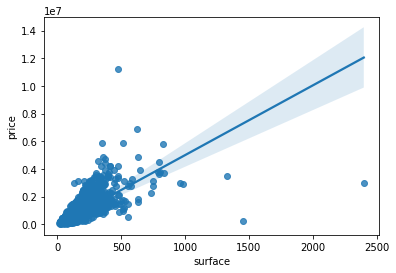

In [97]:
sns.regplot(data = df , x = 'surface' , y = 'price')

In [98]:
df_logtarget = df.copy()
df_logtarget['price'] = np.log(df_logtarget['price'])

<AxesSubplot:xlabel='surface', ylabel='price'>

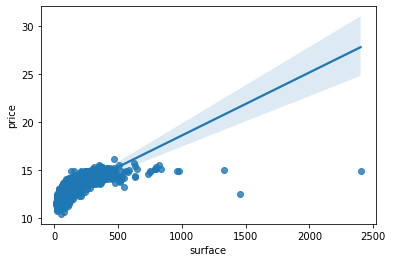

In [99]:
sns.regplot(data = df_logtarget , x = 'surface' , y = 'price')